In [276]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import matplotlib as mpl

In [277]:
def adjust_spines2(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])
        
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [278]:
#ifile = f"./Catalonia/data_41.29927793_2.037869852"
ifile = f"./Catalonia/data_42.2583879_2.364296903"
obs = pd.read_csv(ifile,parse_dates=True, sep=' ',names=['year','month','day','hour','pr'])
obs['datetime']=pd.to_datetime(obs[['year', 'month', 'day', 'hour']])
obs = obs.set_index('datetime')
obs = obs['pr']

In [279]:
obs_day = obs.resample("D").sum()
obs_day_x = obs_day.where((obs_day>25) & (obs_day<30))
obs_x = obs.where(obs_day_x.resample('1H').ffill().notna()).dropna()
obs_x_wet = obs_x.where(obs_x>1)

In [280]:
obs_x_wet.groupby(obs_x_wet.index.date).count()

1996-01-23     8
1996-03-07     4
1996-04-17     4
1997-01-03     7
1997-08-26     5
1997-11-06     6
1997-12-17    12
1998-05-26     2
1998-08-18     2
1998-10-02     2
1999-01-10    11
2001-06-27     5
2001-10-20     5
2002-04-11     8
2002-05-10     7
2003-05-19     4
2003-09-28     5
2003-10-01     4
2004-06-11     3
2005-02-07    11
2005-05-22     2
2006-01-28    10
2006-04-20     3
2006-07-28     1
2006-08-15     6
2007-04-14    13
2008-03-30     4
2008-05-09    11
2008-11-01     7
2009-06-26     3
2010-05-13     7
2011-06-10     6
2011-11-04    12
2012-04-04     9
2012-08-06     4
2012-08-30     6
2012-09-09     2
2013-09-29     6
2014-06-24     3
2014-11-28    10
2015-06-22     5
2015-07-22     5
2015-08-17     5
2015-11-03     3
Name: pr, dtype: int64

Working with series and streaks

In [281]:
srain = pd.Series(obs)

srain =srain.to_frame()
srain = srain.rename(columns = {0:'pr'})

srain['event_start'] = (srain['pr'].astype(bool).shift() != srain['pr'].astype(bool))
srain['event_end'] = (srain['pr'].astype(bool).shift(-1) != srain['pr'].astype(bool))
srain['event'] = srain['event_start'].cumsum()

wet_event_intensity = srain.groupby('event')['pr'].sum()
wet_event_duration = srain.groupby('event')['pr'].count()
srain['event_pr'] = srain['event'].map(wet_event_intensity).where(srain['event_end'])
srain['event_dur'] =  srain['event'].map(wet_event_duration).where(srain['event_end'])
srain['event_int'] = srain['event_pr']/srain['event_dur']

srain['day'] = srain.index.normalize()
session_map = srain[srain['pr'].astype(bool)].groupby('day')['event'].nunique()
hour_map = srain[srain['pr'].astype(bool)].groupby('day')['event'].count()

srain['sessions'] = srain['day'].map(session_map)
srain['hours'] = srain['day'].map(hour_map)

# calculate events stats
res = srain.groupby(['day', 'hours', 'sessions'], as_index=False)['pr'].sum()

res['duration'] = res['hours'] / res['sessions']
res['amount'] = res['pr'] / res['sessions']
res['maxrate'] = srain.groupby(['day', 'hours', 'sessions'], as_index=False)['pr'].max()['pr'].values




In [282]:
#filter events to select them
res.where((res['pr']>25) & (res['pr']<30)).dropna().set_index('day')

,hours,sessions,pr,duration,amount,maxrate
day,,,,,,
1996-01-23,10.0,1.0,26.2,10.000000,26.200000,6.4
1996-03-07,6.0,1.0,25.6,6.000000,25.600000,9.8
1996-04-17,4.0,1.0,25.4,4.000000,25.400000,10.2
1997-01-03,7.0,1.0,27.4,7.000000,27.400000,8.6
1997-08-26,9.0,4.0,25.6,2.250000,6.400000,8.8
1997-11-06,16.0,5.0,28.0,3.200000,5.600000,12.2
1997-12-17,20.0,3.0,26.4,6.666667,8.800000,3.0
1998-05-26,3.0,2.0,25.6,1.500000,12.800000,17.2
1998-08-18,3.0,2.0,29.6,1.500000,14.800000,26.0


### PREPARING DATA FOR PLOTS

In [283]:
ext_type=np.zeros((3,24),dtype=np.float)
real_type=np.zeros((3,24),dtype=np.float)

Selecting real cases

In [284]:
# real_type[0,:]= obs.loc['2011-07-19'].values # '2006-08-25';'1993-08-15'
# real_type[1,:]= obs.loc['2008-05-09'].values # '2013-03-05'; '2008-05-09'
# real_type[2,:]= obs.loc['1995-08-24'].values #'1993-08-24'; '1995-08-24'; '1997-12-16'

In [320]:
real_type[0,:]= obs.loc['2002-04-09'].values 
real_type[1,:]= obs.loc['1996-11-17'].values 
real_type[2,:]= obs.loc['2002-05-09'].values 

In [321]:
dxr=xr.Dataset({'PR':(['event','hour'],real_type)},coords={'hour':np.arange(24),'event':['extreme','distributed','two peaks']})

Creating idealised cases

In [288]:
ext_type[0,18:20]=np.asarray([4,46])
#ext_type[1,:]=np.random.dirichlet(np.ones(24),size=1)
ext_type[1,:]=np.asarray([1,2,1,1,3,1,4,6,5,7,10,8,4,6,2,1,1,2,1,2,4,2,1,1])
ext_type[2,:]=np.asarray([0,0,0,2,8,1,0,0,0,0,0,0,0,1,10,2,1,0,0,0,0,0,0,0])
ext_type=ext_type/np.sum(ext_type,axis=1)[:, np.newaxis]*30

In [289]:
ch_gauss=np.zeros((3,24),dtype=np.float)
ch_gauss[0,:]=gaussian(np.arange(24),15,2)*6
ch_gauss[2,:]=gaussian(np.arange(24),15,2.62)*5.5

ch_gauss[0,:][ch_gauss[0,:]<0.1]=0
ch_gauss[2,:][ch_gauss[2,:]<0.1]=0

ch_gauss[1,:]=gaussian(np.arange(24),15,1)
# ch_gauss[2,:]=gaussian(np.arange(24),15,2)
ch_gauss[1,:]=ch_gauss[1,:]*ch_gauss[0,:].sum()/ch_gauss[1,:].sum()
# ch_gauss[2,:]=ch_gauss[2,:]*1.2*ch_gauss[0,:].sum()/ch_gauss[2,:].sum()

#max_gauss=np.max(ch_gauss[0,:])
#ch_gauss[2,:]=ch_gauss[0,:]+ch_gauss[0,:]**(0.5)*(1-ch_gauss[0,:]/max_gauss)

### PLOTTING

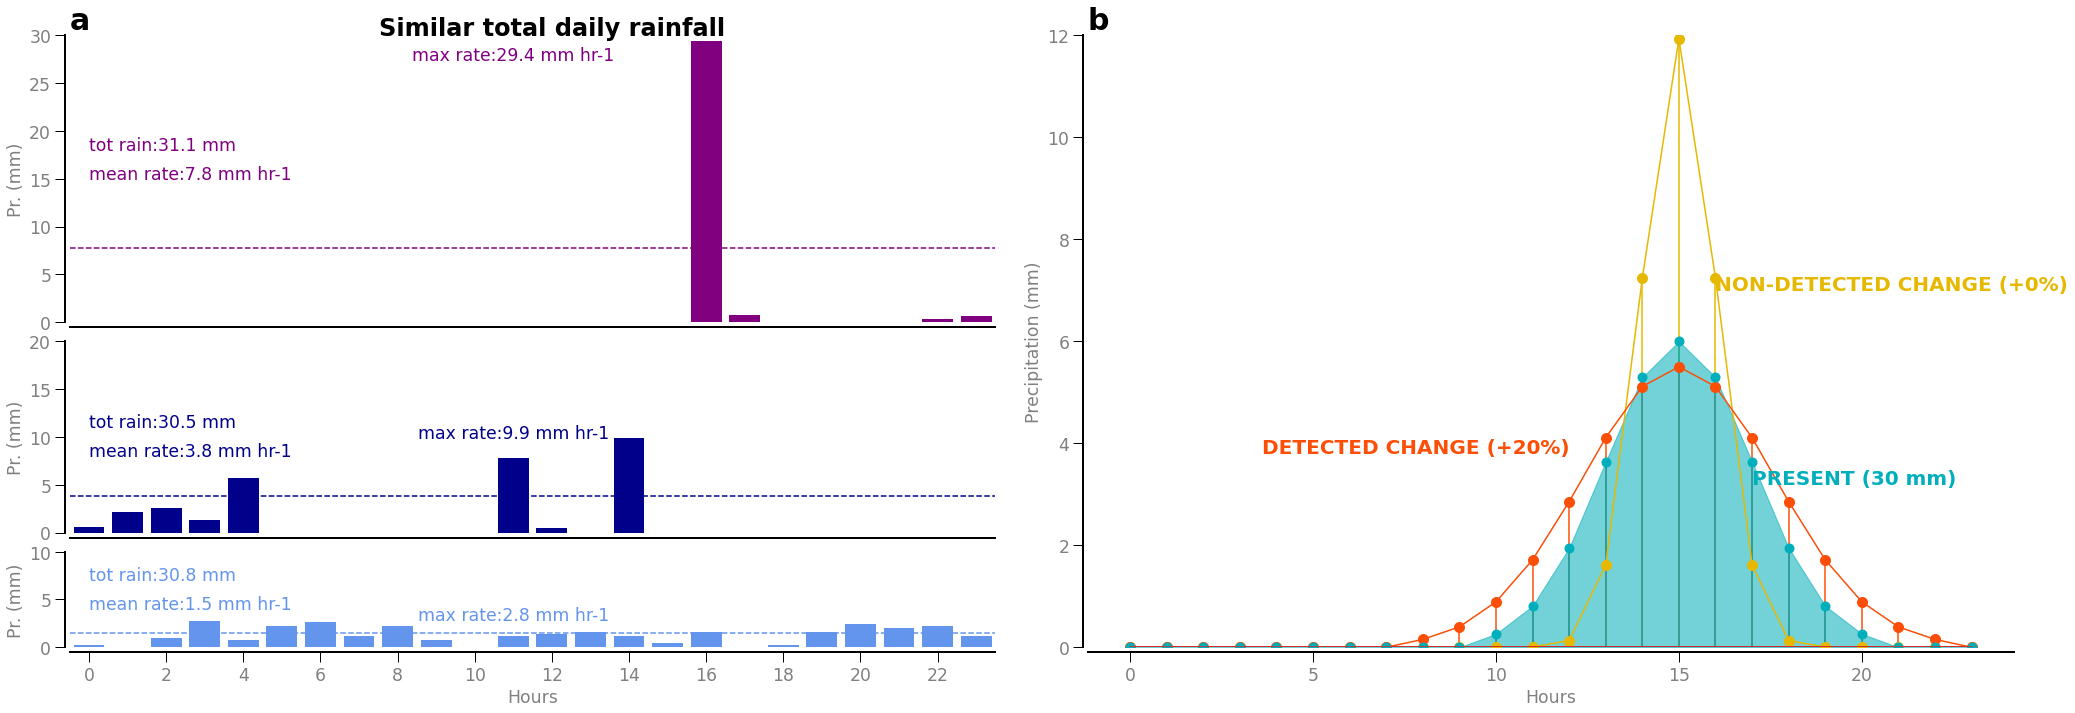

In [322]:
# fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, gridspec_kw={'height_ratios': [3, 2,1]},figsize=(30, 10))

fig = plt.figure(figsize=(30,10),constrained_layout=False)
widths = [1,1]
heights = [3,2,1]


spec = fig.add_gridspec(ncols=2, nrows=3, width_ratios=widths,
                          height_ratios=heights)


#EXTREME
ax01=fig.add_subplot(spec[0,0])
ax01.bar(np.arange(24),dxr.PR.sel(event='extreme'),color='purple')

ax01.set_ylim(0,30)
mean_rain=dxr.PR.sel(event='extreme').where(dxr.PR.sel(event='extreme')>0).mean().values
tot_rain = dxr.PR.sel(event='extreme').sum().values
ax01.axhline(mean_rain,color='purple',linestyle='--')
ax01.text(0,15,f"mean rate:{mean_rain:.1f} mm hr-1",\
            ha='left',color='purple',fontsize='xx-large')
ax01.text(0,18,f"tot rain:{tot_rain:.1f} mm",\
            ha='left',color='purple',fontsize='xx-large')
ax01.text(12,30,f"Similar total daily rainfall",
            ha='center',color='k',fontsize=24,fontweight= 'bold')

ax01.set_xlim(-0.5,23.5)
adjust_spines2(ax01, ['left','bottom','top','right'])
ax01.axes.get_xaxis().set_visible(False)
ax01.set_ylabel('Pr. (mm)',size='xx-large',color='gray')
ax01.spines['top'].set_color('none')
ax01.spines['right'].set_color('none')
ax01.spines['left'].set_linewidth(2)
ax01.spines['bottom'].set_linewidth(2)
ax01.tick_params(labelcolor='gray',labelsize='xx-large', width=1,length=10)
ax01.set_title('a',loc='left',fontsize=30,fontweight='bold')

#peak
maxr = dxr.PR.sel(event='extreme').where(dxr.PR.sel(event='extreme')>0).max().values
hourx = dxr.PR.sel(event='extreme').argmax().values
ax01.text(11,maxr-2,f"max rate:{maxr:.1f} mm hr-1",\
            ha='center',color='purple',fontsize='xx-large')


#TWO PEAKS
ax02=fig.add_subplot(spec[1,0])
ax02.bar(np.arange(24),dxr.PR.sel(event='two peaks'),color='darkblue')
mean_rain=dxr.PR.sel(event='two peaks').where(dxr.PR.sel(event='two peaks')>0).mean().values
tot_rain = dxr.PR.sel(event='two peaks').sum().values
ax02.axhline(mean_rain,color='darkblue',linestyle='--')
ax02.text(0,8,f"mean rate:{mean_rain:.1f} mm hr-1",\
            ha='left',color='darkblue',fontsize='xx-large')
ax02.text(0,11,f"tot rain:{tot_rain:.1f} mm",\
            ha='left',color='darkblue',fontsize='xx-large')
ax02.set_ylim(0,20)
#ax02.set_yticks(np.arange(0,15,5))
ax02.set_xlim(-0.5,23.5)
adjust_spines2(ax02, ['left','bottom','top','right'])
ax02.axes.get_xaxis().set_visible(False)
ax02.set_ylabel('Pr. (mm)',size='xx-large',color='gray')
ax02.spines['top'].set_color('none')
ax02.spines['right'].set_color('none')
ax02.spines['left'].set_linewidth(2)
ax02.spines['bottom'].set_linewidth(2)
ax02.tick_params(labelcolor='gray',labelsize='xx-large', width=1,length=10)

#peak
maxr = dxr.PR.sel(event='two peaks').where(dxr.PR.sel(event='two peaks')>0).max().values
hourx = dxr.PR.sel(event='two peaks').argmax().values
ax02.text(11,maxr,f"max rate:{maxr:.1f} mm hr-1",\
            ha='center',color='darkblue',fontsize='xx-large')





#DIST
ax03=fig.add_subplot(spec[2,0])
ax03.bar(np.arange(24),dxr.PR.sel(event='distributed'),color='cornflowerblue')
mean_rain=dxr.PR.sel(event='distributed').where(dxr.PR.sel(event='distributed')>0).mean().values
tot_rain = dxr.PR.sel(event='distributed').sum().values
ax03.axhline(mean_rain,color='cornflowerblue',linestyle='--')
ax03.text(0,4,f"mean rate:{mean_rain:.1f} mm hr-1",\
            ha='left',color='cornflowerblue',fontsize='xx-large')
ax03.text(0,7,f"tot rain:{tot_rain:.1f} mm",\
            ha='left',color='cornflowerblue',fontsize='xx-large')
adjust_spines2(ax03, ['left','bottom','top','right'])
ax03.set_xticks(np.arange(0,23,2))
ax03.set_xlim(-0.5,23.5)
ax03.set_ylim(0,10)
#ax03.set_yticks(np.arange(0,6,2))
ax03.tick_params(labelcolor='gray',labelsize='xx-large', width=1,length=10)
ax03.set_ylabel('Pr. (mm)',size='xx-large',color='gray')
ax03.set_xlabel('Hours',size='xx-large',color='gray')
ax03.spines['top'].set_color('none')
ax03.spines['right'].set_color('none')
ax03.spines['left'].set_linewidth(2)
ax03.spines['bottom'].set_linewidth(2)
ax03.tick_params(labelcolor='gray',labelsize='xx-large', width=1,length=10)

#peak
maxr = dxr.PR.sel(event='distributed').where(dxr.PR.sel(event='distributed')>0).max().values
hourx = dxr.PR.sel(event='distributed').argmax().values
ax03.text(11,maxr,f"max rate:{maxr:.1f} mm hr-1",\
            ha='center',color='cornflowerblue',fontsize='xx-large')


    
ax04=fig.add_subplot(spec[:,1])
ax04.set_title('b',loc='left',fontsize=30,fontweight='bold')
ax04.stem(np.arange(24),ch_gauss[0,:],linefmt="#00AFBB")




(markers, stemlines, baseline) = ax04.stem(np.arange(24),ch_gauss[1,:],linefmt="#E7B800",markerfmt="#E7B800")
plt.setp(markers, marker='o', markersize=10, markerfacecolor="#E7B800")
ax04.text(16,7,'NON-DETECTED CHANGE (+0%)',fontweight='bold',fontsize=20,color="#E7B800")

(markers, stemlines, baseline) = ax04.stem(np.arange(24),ch_gauss[2,:],linefmt="#FC4E07",markerfmt="#FC4E07")
plt.setp(markers, marker='o', markersize=10, markerfacecolor="#FC4E07")
ax04.text(12,3.8,'DETECTED CHANGE (+20%)',ha='right',fontweight='bold',fontsize=20,color="#FC4E07")


(markers, stemlines, baseline) = ax04.stem(np.arange(24),ch_gauss[0,:],linefmt="#00AFBB")
plt.setp(markers, marker='o', markersize=10, markerfacecolor="#00AFBB", markeredgewidth=0)
ax04.fill_between(np.arange(24), ch_gauss[0,:], y2=0,color="#00AFBB",alpha=0.5)
ax04.text(17,3.2,f'PRESENT ({ch_gauss[0,:].sum():.0f} mm)',fontweight='bold',fontsize=20,color="#00AFBB")

ax04.fill_between(np.arange(24), ch_gauss[0,:], y2=0,color="#00AFBB",alpha=0.1)
# ax04.stem(np.arange(24),ch_gauss[1,:],linefmt="#E7B800")
# ax04.stem(np.arange(24),ch_gauss[2,:],linefmt="#FC4E07", markerfmt="#FC4E07")

adjust_spines2(ax04, ['left','bottom','top','right'])
ax04.spines['top'].set_color('none')
ax04.spines['right'].set_color('none')
ax04.spines['left'].set_linewidth(2)
ax04.spines['bottom'].set_linewidth(2)
ax04.tick_params(labelcolor='gray',labelsize='xx-large', width=1,length=10)
ax04.set_xlabel('Hours',color='gray',size='xx-large')
ax04.set_ylabel('Precipitation (mm)',color='gray',size='xx-large') 
ax04.set_ylim(0,12)
    
    
fig.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.1,wspace=0.1,hspace=0.1)#
plt.savefig('Schematic_dailyvshourly_BCN.png',dpi=150)

In [291]:
dxr.PR.sel(event='distributed').where(dxr.PR.sel(event='distributed')>0).max().values

array(5.)

In [292]:
dxr.PR.sel(event='distributed')

<xarray.DataArray 'PR' (hour: 24)>
array([0. , 0. , 0. , 0.4, 1.3, 0. , 0. , 0. , 1.5, 0.8, 0.6, 1.1, 0.4,
       0.1, 0.4, 3.5, 3.4, 3. , 2.7, 2.4, 1.7, 1.1, 1.8, 5. ])
Coordinates:
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
    event    <U11 'distributed'